### Résolution du problème _Soft Support Vector Machine_ par Descente de Gradient et par Descente de Gradient Stochastique

Voir chapitre 15 du livre Understanding Machine Learning de S. Shalev-Shwartz et S. Ben-David

In [17]:
using Random
using Gadfly
using LinearAlgebra
using DataFrames

In [18]:
hinge_loss(x :: Float64 ) = max(0,1-x)

hinge_loss (generic function with 1 method)

In [19]:
mutable struct HyperPlan{d}
    
    w :: Vector{Float64}
    b :: Float64
    
    function HyperPlan{d}() where {d}
        new(zeros(d), 0.0)
    end
    
    function HyperPlan{d}(w :: Vector{Float64}) where {d}
        n = length(w)
        if d >= n
            w = [w;zeros(d-n)]
        else
            w = w[1:d]
        end
        new(w, 0.0)
    end   
    
    function HyperPlan{d}(w :: Vector{Float64}, 
                          b :: Float64) where {d}
        n = length(w)
        d >= n && (w = [w;zeros(d-n)])
        d >= n || (w = w[1:d])
        new(w, b)
    end
end

Base.ndims(::HyperPlan{d}) where {d} = d

In [20]:
function (h :: HyperPlan)( x :: Vector{Float64})
    dot(h.w, x) + h.b
end

In [21]:
import Base:+

function +(h1 :: HyperPlan{d}, h2 :: HyperPlan{d}) where {d}

    HyperPlan{d}(h1.w + h2.w, h1.b + h2.b)

end

+ (generic function with 230 methods)

In [22]:
import Base:-

function -(h1 :: HyperPlan{d}, h2 :: HyperPlan{d}) where {d}

    HyperPlan{d}(h1.w - h2.w, h1.b - h2.b)

end

- (generic function with 230 methods)

In [23]:
function external_prod(h :: HyperPlan{d}, 
                       a :: Float64) where {d} 
    
    HyperPlan{d}(h.w .* a, h.b * a)
    
end

external_prod (generic function with 1 method)

In [24]:
square(h :: HyperPlan) = dot(h.w, h.w) + h.b^2

square (generic function with 1 method)

In [25]:
function gradient_loss(h     :: HyperPlan{d}, 
                       x     :: Vector{Float64}, 
                       y     :: Float64, 
                       lambd :: Float64) where {d}
    if y * h(x) < 1
        v1 = lambd .* h.w .- y .* x
        v2 = lambd * h.b - y
    else
        v1 = lambd .* h.w
        v2 = lambd * h.b
    end
    HyperPlan{d}(v1, v2)
end

gradient_loss (generic function with 1 method)

In [49]:
function SGD(h     :: HyperPlan{d}, 
             x     :: Array{Float64,2}, 
             y     :: Vector{Float64}, 
             lambd :: Float64,  
             niter     = 1000, 
             learning  = 0.1, 
             averaging = 1) where {d}
    
    i0       = abs(niter-averaging)
    liste    = HyperPlan{d}[]
    push!(liste, h)
    res0, res1 = h, h
    n = length(y)
    for i in 1:niter
        it = rand(1:n)
        vt = gradient_loss(res0, x[it,:], y[it], lambd)
        res0 = res0 - external_prod(vt,learning/(1+learning*lambd*i))
        push!(liste, res0)
        mut = 1/max(1,i-i0)
        res1 = (external_prod(res1, 1-mut)
            + external_prod(res0, mut))
        @show res1
    end
    res1, liste
end

SGD (generic function with 4 methods)

In [50]:
using LinearAlgebra

mutable struct Polynomial
    
    weights :: Array{Float64, 2}
    void    :: Array{Float64, 2}

    function Polynomial(w)
        d = size(w)[1]
        void = zeros(Float64, (d,d))
        for i in 1:d
            for j in 1:d-i+1
                void[i,j] = 1
            end
        end
        weights = void .* w
        new( weights, void)
    end
end

degree(p :: Polynomial) = size(p.weights)[1]-1
    
function (p :: Polynomial)( x :: Vector{Float64} )
    @assert length(x) > 1
    X1 = [x[1]^exp for exp in 0:degree(p)]
    X2 = [x[2]^exp for exp in 0:degree(p)]
    ((p.weights * X1)' * X2)[1,1]
end

In [51]:
# Les paramètres :
# dimension de l'espace des x
h = HyperPlan{2}()
# degré du polynôme de départ
deg = 1
# on introduit ce petit pourcentage d'erreurs dans les données
seuil_erreur = 0.
# taille de l'échantillon de données d'entraînement
m=100
# taille de l'échantillon de données de test 
mtest=1000
# bornes sur l'espace des données x
xmax =  1.25
xmin = -1.25
# valeur de lambda pour le soft-SVM
lambd=1.
# valeur du taux d'apprentissage initialement pour le soft-SVM
learning  = 0.1
# taille du stencil pour l'averaging dans la SGD
averaging = 10

10

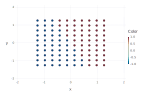

In [52]:
# fabrication des données
Random.seed!(1234)
w   = reshape(collect(0:(deg+1)*(deg+1)-1),deg+1,deg+1)
w[1,1] = 0.0

pf = Polynomial(w)
#x  = xmin .+ (xmax .- xmin) .* rand(Float64,(m, ndims(h)))
x1 = collect(range(xmin, stop=xmax, length=10))  .* ones(10)'
x2 = collect(range(xmin, stop=xmax, length=10))' .* ones(10)
x  = hcat(vec(x1),vec(x2))

u  = rand(Float64,m)
y  = zeros(m)
y[ u .>  seuil_erreur ] .=   sign.([pf(x[i,:]) for i in 1:m if u[i] >   seuil_erreur])
y[ u .<= seuil_erreur ] .= - sign.([pf(x[i,:]) for i in 1:m if u[i] <=  seuil_erreur])

plot(x = x[:,1], y = x[:,2], color = y)

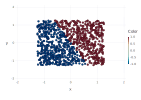

In [53]:
Random.seed!(5678)
xtest = xmin .+ (xmax - xmin) .* rand(Float64,( mtest, ndims(h)))
ytest = sign.([pf(xtest[i,:]) for i in 1:mtest])
plot(x = xtest[:,1], y = xtest[:,2], color = ytest)

In [54]:
# Résolution du problème soft-SVM

h, liste = SGD(h, x, y, lambd, 200, learning, averaging)

res1 = HyperPlan{2}([0.0631313, 0.113636], 0.09090909090909091)
res1 = HyperPlan{2}([0.0694444, 0.208333], 0.16666666666666669)
res1 = HyperPlan{2}([0.138889, 0.245726], 0.23076923076923078)
res1 = HyperPlan{2}([0.178571, 0.218254], 0.14285714285714285)
res1 = HyperPlan{2}([0.25, 0.138889], 0.2)
res1 = HyperPlan{2}([0.260417, 0.121528], 0.125)
res1 = HyperPlan{2}([0.253268, 0.155229], 0.058823529411764705)
res1 = HyperPlan{2}([0.308642, 0.169753], -6.938893903907228e-18)
res1 = HyperPlan{2}([0.314327, 0.138889], -0.05263157894736843)
res1 = HyperPlan{2}([0.305556, 0.166667], -1.3877787807814457e-17)
res1 = HyperPlan{2}([0.350529, 0.191799], -0.04761904761904763)
res1 = HyperPlan{2}([0.391414, 0.164141], -6.938893903907228e-18)
res1 = HyperPlan{2}([0.416667, 0.163043], -0.04347826086956523)
res1 = HyperPlan{2}([0.451389, 0.173611], -1.3877787807814457e-17)
res1 = HyperPlan{2}([0.483333, 0.138889], -0.040000000000000015)
res1 = HyperPlan{2}([0.512821, 0.160256], -1.3877787807814457e-17)


res1 = HyperPlan{2}([0.628613, 0.145311], 0.05202312138728322)
res1 = HyperPlan{2}([0.622605, 0.150064], 0.05747126436781607)
res1 = HyperPlan{2}([0.619841, 0.151587], 0.05142857142857141)
res1 = HyperPlan{2}([0.621843, 0.151515], 0.045454545454545435)
res1 = HyperPlan{2}([0.625392, 0.151444], 0.03954802259887004)
res1 = HyperPlan{2}([0.62578, 0.145131], 0.03370786516853931)
res1 = HyperPlan{2}([0.627716, 0.149752], 0.039106145251396635)
res1 = HyperPlan{2}([0.626543, 0.149691], 0.03333333333333332)
res1 = HyperPlan{2}([0.623849, 0.154236], 0.038674033149171255)
res1 = HyperPlan{2}([0.621184, 0.160256], 0.032967032967032954)
res1 = HyperPlan{2}([0.624621, 0.155586], 0.027322404371584688)
res1 = HyperPlan{2}([0.62651, 0.161534], 0.032608695652173905)
res1 = HyperPlan{2}([0.628378, 0.165916], 0.027027027027027018)
res1 = HyperPlan{2}([0.63172, 0.162784], 0.021505376344086013)
res1 = HyperPlan{2}([0.632056, 0.168598], 0.026737967914438495)
res1 = HyperPlan{2}([0.632388, 0.161052], 0.03191

(HyperPlan{2}([0.64349, 0.181176], 0.03267486645080611), HyperPlan{2}[HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0631313, 0.113636], 0.0909091), HyperPlan{2}([0.0694444, 0.208333], 0.166667), HyperPlan{2}([0.138889, 0.245726], 0.230769), HyperPlan{2}([0.178571, 0.218254], 0.142857), HyperPlan{2}([0.25, 0.138889], 0.2), HyperPlan{2}([0.260417, 0.121528], 0.125), HyperPlan{2}([0.253268, 0.155229], 0.0588235), HyperPlan{2}([0.308642, 0.169753], -6.93889e-18), HyperPlan{2}([0.314327, 0.138889], -0.0526316)  …  HyperPlan{2}([0.644693, 0.172056], 0.0348259), HyperPlan{2}([0.646315, 0.177393], 0.039604), HyperPlan{2}([0.646552, 0.181308], 0.044335), HyperPlan{2}([0.64134, 0.186547], 0.0392157), HyperPlan{2}([0.640244, 0.189024], 0.0341463), HyperPlan{2}([0.641855, 0.182039], 0.0291262), HyperPlan{2}([0.64211, 0.177805], 0.0241546), HyperPlan{2}([0.641026, 0.181624], 0.0288462), HyperPlan{2}([0.643939, 0.182749], 0.0239234), HyperPlan{2}([0.646825, 0.181217], 0.0285714)])

In [55]:
h

HyperPlan{2}([0.64349, 0.181176], 0.03267486645080611)

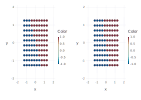

In [56]:
function affiche(x, y, h :: HyperPlan)
    m = length(y)
    yresult = [sign(h(x[i,:])) for i in 1:m]
    
    p1 = plot( x = x[:,1], y = x[:,2], color=y)
    p2 = plot( x = x[:,1], y = x[:,2], color=yresult)
    
    hstack(p1, p2)
end

affiche(x, y, h)

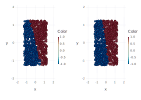

In [57]:
affiche(xtest,ytest,h)

In [16]:
function loss(h :: HyperPlan{d}, 
     x :: Vector{Float64}, 
     y :: Float64) where {d} 
    
    hinge_loss(y * h(x))
end

function risk(h     :: HyperPlan{d}, 
              x     :: Array{Float64, d}, 
              y     :: Array{Float64, 1}, 
              lambd :: Float64) where {d}
    
    (lambd/2 * square(h)
        +1/length(y)*sum([loss(h, x[i,:], y[i]) 
                for i in 1:size(x)[1]]))
end 

function risk_vrai(h :: HyperPlan{d}, 
                   x :: Array{Float64,d}, 
                   y :: Vector{Float64}) where {d}
    n = length(y)
    @assert n == size(x)[1]
    sum([sign.(h(x[i,:])) != y[i] for i in 1:n])/n
end

risk_vrai (generic function with 1 method)

In [14]:
function affiche_risques(liste, x, y, lambd)
    y1 = [risk(h, x, y, lambd) for h in liste]
    y2 = [risk_vrai(h, x, y) for h in liste]
    df1 = DataFrame( x = collect(1:length(liste)), 
        y = y1, label = :risque)
    df2 = DataFrame( x = collect(1:length(liste)), 
        y = y2, label = :risque_vrai)
    df = vcat(df1,df2)
    plot(df, x=:x, y=:y, Geom.line, 
        color= :label, 
        Scale.color_discrete_manual("blue","red"))
end

affiche_risques (generic function with 1 method)

In [15]:
affiche_risques(liste,xtest,ytest,lambd)

UndefVarError: UndefVarError: liste not defined